In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12


In [3]:
fname_spc = '../data/spc_giants.csv' # original
fname_spc = '../data/smear_spc_new.txt' # updated 
fname_spc = '../data/SMEAR_SPC_first_iteration.txt' # new targets
fname_spc = '../data/smear_spc_2.txt' # new targets 

fname_guy = '../data/smear_Dnu.csv' 

In [5]:
spc_data = Table.read(fname_spc,format='ascii')

guy_data = Table.read(fname_guy,format='ascii')
guy_data.rename_column('Star_ID','Object')
print guy_data.keys()
print spc_data.keys()

['Object', 'Dnu', 'Dnu_err', 'Numax', 'Numax_err', 'eps', 'eps_err']
['Object', 'BJD_TDB', 'RV', 'RVerr', 'Teff', 'Teff_err', 'logg', 'logg_err', 'monh', 'monh_err', 'vsini', 'vsini_err', 'CCF', 'SNRe', 'n_aps', 'exptime', 'spectro', 'res', 'method']


In [6]:
new_stars = ['HD_175466','BD+42_3150','BD+48_2904','HD_176209','HD_182354','HD_189636B','HD_189636A','HD_189750']

In [7]:
for star in new_stars:
    if star in guy_data['Object']:
        print star

BD+42_3150
BD+48_2904
HD_176209
HD_182354
HD_189750


In [8]:
guy_data.sort('Object')
spc_data.sort('Object')

In [9]:
spc_data

Object,BJD_TDB,RV,RVerr,Teff,Teff_err,logg,logg_err,monh,monh_err,vsini,vsini_err,CCF,SNRe,n_aps,exptime,spectro,res,method
str10,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,str4,str1,str6
BD+42_3150,2458377.631807,-26.519,0.065,4775.74,50,2.48,0.1,-0.194,0.08,4.22,0.5,0.9885,90.4,3,350.0,tres,m,SPC2.9
BD+48_2904,2458384.778439,5.24,0.025,4484.32,50,2.25,0.1,-0.3,0.08,4.11,0.5,0.9838,59.8,3,240.0,tres,m,SPC2.9
HD_176209,2458378.633415,-12.906,0.93,8097.02,71,2.58,0.122,-0.083,0.08,49.84,0.5,0.8807,98.1,3,300.0,tres,m,SPC2.9
HD_182354,2458379.614475,-36.788,0.056,4697.05,50,2.29,0.1,-0.301,0.08,5.38,0.5,0.9878,166.5,3,200.0,tres,m,SPC2.9
HD_189750,2458384.795003,-62.645,0.061,4814.07,50,2.46,0.1,-0.344,0.08,4.15,0.5,0.9857,100.8,3,360.0,tres,m,SPC2.9


In [10]:
numax_sun = 3160.
numax_sun_err = 10.

Teff_sun = 5777.
logg_sun = 4.43812

In [11]:
mapping = np.array([np.where(guy_data['Object'][:]==obj)[0][0] for obj in spc_data['Object'] if (obj in guy_data['Object'])])
missing = np.array([obj not in guy_data['Object'] for obj in spc_data['Object']])

In [12]:
# new_table = join(guy_data[mapping],spc_data[~missing])
new_table = join(guy_data,spc_data)

In [13]:
# spc_data['Object'].pprint(max_lines=70)

In [14]:
# new_table.keys()

In [15]:
g = ((new_table['Teff']/Teff_sun)**0.5) * (new_table['Numax']/numax_sun)
log_g = np.log10(g)+logg_sun

In [16]:
# new_table['logg']

## Now we do it with Monte Carlo

In [17]:
teffs = new_table['Teff'] 
numaxes = new_table['Numax']
numax_errs = new_table['Numax_err']
N = len(teffs)

# data = dict(teff=teffs,mu_numax=numaxes,sig_numax=numax_errs,numax_sun=numax_sun,teff_sun=Teff_sun,N=N)

In [18]:
log_g = []
log_g_err = []

for j in range(N):
    thisnumax = numax_errs[j]*np.random.randn(10000)+numaxes[j]
    thislogg = np.log10((teffs[j]/Teff_sun)**0.5 * (thisnumax/numax_sun))
    log_g.append(np.mean(thislogg))
    log_g_err.append(np.std(thislogg))
    
log_g = np.array(log_g)+logg_sun
log_g_err = np.array(log_g_err)

(array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1.]),
 array([32.01835278, 35.48618604, 38.9540193 , 42.42185256, 45.88968582,
        49.35751908, 52.82535234, 56.29318559, 59.76101885, 63.22885211,
        66.69668537]),
 <a list of 10 Patch objects>)

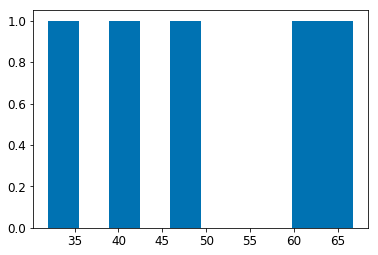

In [19]:
plt.hist(numaxes/numax_errs)

In [20]:
new_table['Object'].pprint(max_lines=40)

  Object  
----------
BD+42_3150
BD+48_2904
 HD_176209
 HD_182354
 HD_189750


In [27]:
output = Table({'Object':new_table['Object'],
                'numax':numaxes,
                'numax_err':numax_errs,
                'log_g':log_g,
                'log_g_err':log_g_err})
output = output['Object','numax','numax_err','log_g','log_g_err']
output.write('pope_asteroseismology_newtargs.csv',format='csv')

In [26]:
output

Object,log_g,log_g_err,numax,numax_err
str10,float64,float64,float64,float64
BD+42_3150,2.4802800497112907,0.010819980855461032,38.315943379269186,0.9588694546996247
BD+48_2904,2.247097436335569,0.013705898434274975,23.13453453354469,0.7225398099392429
HD_176209,2.5687842882541227,0.00930048930883258,36.07827845578754,0.7700293923582229
HD_182354,2.2867772572445646,0.006530061705894164,24.73075125143719,0.3707943073028773
HD_189750,2.4567819822893022,0.006900478594531732,36.14219592398721,0.5754661116683394


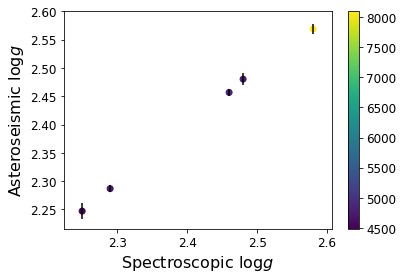

In [23]:
plt.scatter(new_table['logg'],log_g,c=new_table['Teff'])
plt.errorbar(new_table['logg'],log_g,yerr=log_g_err,linestyle='',color='k')
plt.colorbar()
plt.xlabel(r'Spectroscopic $\log{g}$')
plt.ylabel(r'Asteroseismic $\log{g}$')
plt.savefig('numax_correlation.png')

In [24]:
# output

In [26]:
spc_data['Object'].pprint(max_lines=70)

  Object  
----------
BD+36_3564
BD+39_3577
BD+42_3367
BD+42_3393
BD+43_3064
BD+43_3171
BD+43_3213
BD+48_2955
 HD_174020
 HD_174676
 HD_174829
 HD_175740
 HD_175740
 HD_175740
 HD_175740
 HD_175740
 HD_175884
 HD_176466
 HD_178797
 HD_178910
 HD_179394
 HD_179396
 HD_179959
 HD_180312
 HD_180312
 HD_180475
 HD_180658
 HD_180682
 HD_181022
 HD_181069
 HD_181097
 HD_181328
 HD_181596
 HD_181597
 HD_181681
 HD_181778
 HD_181878
 HD_181880
 HD_182531
 HD_182692
 HD_182694
 HD_183124
 HD_183203
 HD_184483
 HD_184787
 HD_185286
 HD_185351
 HD_185351
 HD_185351
 HD_185524
 HD_186121
 HD_186727
 HD_187217
 HD_187372
 HD_188537
 HD_188629
 HD_188875
 HD_188875
 HD_190149
 HD_226754
  V398_Lyr
  V546_Lyr
  V547_Lyr
